In [1]:
import time
import numpy as np
import clfanalysis
from clfanalysis.preamble import *
import matplotlib.pyplot as plt
import copy

def cm2inch(cm):
    return cm / 2.54

startscript = time.time()

# Assignment 2

Each notebook tests a single classifer type on a dataset.

The classifier options are set by `clf_flag`:

    'lr': Logistic Regression Classifier
    'mpl': Multi-Layer Perceptron Classifier
    'rf' : Random Forest Classifier

The dataset options are set by `data_flag`:

    '0' : CIFAR-10 Data
    '1' : Fashion-MINST Data

All other global parameters are set by `clfanalysis.globalparams`


In [2]:
clf_flag = 'lr' 
data_flag = 0

### Parameters

In [3]:
from clfanalysis.globalparams import *

### Data Load + Pre-Process

In [4]:
from clfanalysis.preprocess import rescale, greyscale

# load data:
dataset = np.load(loadpath+datafiles[data_flag]+'.npz')
Xtr = dataset['Xtr']
Str = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']


# for MINST
if data_flag == 1: 
    Xtr = rescale(Xtr)
    Xts = rescale(Xts)

# for CIFAR
if data_flag == 0: 

    Xtr = np.asarray([greyscale(np.transpose(Xtr[sample, :].reshape(3, 32, 32), (1, 2, 0))) for sample in range(10000)])
    Xts = np.asarray([greyscale(np.transpose(Xts[sample, :].reshape(3, 32, 32), (1, 2, 0))) for sample in range(2000)])
    Xtr = rescale(Xtr.reshape(10000, 32*32))
    Xts = rescale(Xts.reshape(2000, 32*32))

In [5]:
processtime = time.time()

### Train classifier

In [6]:
from clfanalysis.trainclf import computeAccuracy, train_classifier

results, class_prob_list, best_model_list = train_classifier(clfdict[clf_flag]['obj'], 
                                                             clfdict[clf_flag]['prm'], 
                                                             Xtr, 
                                                             Str, 
                                                             N_ITER, 
                                                             n_repeats, 
                                                             cv=cv, scoring='accuracy')



Trial: 0
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9


In [7]:
traintime = time.time()

### Run Testing with Importance Re-Weighting 

In [14]:
from clfanalysis.noisecorrections import estimate_Beta, estimate_flip_rates, clean_weights
from sklearn.metrics import confusion_matrix



estimatortype = ['tf', 'estf']

if clf_flag == 'mlp':
    estimatortype = [None]

for idx_type in estimatortype + ['bare']:
    if idx_type is not None:
        vars()['acc_'+idx_type] = []

rho_plus_list = []
rho_minus_list = []
cmatrix_list = []
pi_list = []

for pickrept in range(n_repeats):
    
    # Pick best model from each RandomisedCV trial with 5 Fold CV.
    class_prob = class_prob_list[pickrept]
    bestmodel = best_model_list[pickrept]
    params = results[pickrept]["params"][bestmodel]
    
    # Estimate Noise Rates from class probabilities of the model acting on training data
    alpha, beta, pi, rho_plus, rho_minus = estimate_flip_rates(class_prob[:, 1], Str.flatten())
    rho_plus_list.append(rho_plus)
    rho_minus_list.append(rho_minus)
    pi_list.append(pi)
    
    
    # Calculate weights using true and estimated noise rates
    for idx_type in estimatortype:
        
        if idx_type is not None:
        
            if idx_type == 'estf':
                vars()['weights_'+idx_type] = estimate_Beta(Str, class_prob, rho_minus, rho_plus)
            
            elif idx_type == 'tf':
                vars()['weights_'+idx_type] = estimate_Beta(Str, class_prob, rho_0, rho_1)
            
            vars()['weights_'+idx_type] =  clean_weights(vars()['weights_'+idx_type])
        
    pick_data = np.random.randint(low=0, high=10000, size=8000)
    
    # Run new classifiers with best model parameters and importance re-weighting
    for idx_type in estimatortype + ['bare']:
        
        if idx_type is not None:
            
            vars()['clf_'+idx_type] = clfdict[clf_flag]['func'](**params)
            
            X = Xtr[pick_data]
            S = Str.flatten()[pick_data]
            W = None
            
            if idx_type != 'bare':
                W = vars()['weights_'+idx_type].flatten()[pick_data]

            # Fit models
            
            if clf_flag != 'mlp':
                vars()['clf_'+idx_type].fit(X, S, sample_weight=W)
            elif clf_flag == 'mlp':
                vars()['clf_'+idx_type].fit(X, S)

            # Predict on Test Data
            vars()['predY_'+idx_type] = vars()['clf_'+idx_type].predict(Xts)

            # Store accuracy + confusion matrix
            vars()['acc_'+idx_type].append(computeAccuracy(Yts, vars()['predY_'+idx_type]))
            
            if idx_type == 'bare':
                matrixC = confusion_matrix(Yts, vars()['predY_'+idx_type])
                cmatrix_list.append(matrixC.flatten())

In [9]:
endscript = time.time()

print("Approx Total time")
print("%f seconds" %(endscript - startscript))
print()
print("Approx Preprocessing time")
print("%f seconds" %(processtime - startscript))
print("Approx Training time")
print("%f seconds" %(traintime - processtime))
print("Approx Testing time")
print("%f seconds" %(endscript - traintime))

Approx Total time
2840.029048 seconds

Approx Preprocessing time
1.371058 seconds
Approx Training time
2817.437559 seconds
Approx Testing time
21.220431 seconds


### Show accuracy scores for test data

In [15]:
for idx_type in estimatortype + ['bare']:
    
    if idx_type is not None:
        
        print(idx_type + ': ', np.mean(vars()['acc_'+idx_type]))             


tf:  0.5
estf:  0.5087
bare:  0.67765


### Show 'best model' configurations for each experiment

In [16]:
for idx_trial in range(n_repeats):
    print(results[idx_trial]['params'][best_model_list[idx_trial]]), print(results[idx_trial]['mean_test_score'][best_model_list[idx_trial]])
    

{'tol': 0.5, 'solver': 'saga', 'max_iter': 200, 'fit_intercept': False}
0.6235
{'tol': 0.1, 'solver': 'saga', 'max_iter': 150, 'fit_intercept': False}
0.6252
{'tol': 0.1, 'solver': 'saga', 'max_iter': 150, 'fit_intercept': False}
0.6252
{'tol': 1, 'solver': 'saga', 'max_iter': 200, 'fit_intercept': True}
0.6242
{'tol': 0.1, 'solver': 'saga', 'max_iter': 100, 'fit_intercept': True}
0.6215
{'tol': 0.5, 'solver': 'saga', 'max_iter': 100, 'fit_intercept': True}
0.625
{'tol': 0.5, 'solver': 'saga', 'max_iter': 150, 'fit_intercept': True}
0.6228
{'tol': 0.5, 'solver': 'saga', 'max_iter': 250, 'fit_intercept': False}
0.6263
{'tol': 0.1, 'solver': 'saga', 'max_iter': 200, 'fit_intercept': False}
0.6254
{'tol': 0.5, 'solver': 'saga', 'max_iter': 250, 'fit_intercept': True}
0.6245


### Figures

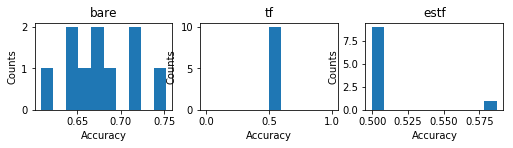

In [18]:
fig = plt.figure(figsize=(21./2.5, 4./2.5))

counter = 1
for idx_type in ['bare'] + estimatortype:
    
    if idx_type is not None:
        
        ax = fig.add_subplot(1, 3, counter)
        ax.hist(vars()['acc_'+idx_type])
        ax.set(xlabel='Accuracy', ylabel='Counts', title=idx_type)
        
        counter += 1
plt.show()

### Save Data

In [19]:
mean_fit_time = np.zeros(n_repeats)
mean_score_time = np.zeros(n_repeats)
mean_train_score = np.zeros(n_repeats)
mean_test_score = np.zeros(n_repeats)
cv_test_score = np.zeros((n_repeats, cv))
cv_train_score = np.zeros((n_repeats, cv))

for idx_rept in range(n_repeats):
    
    best_model = best_model_list[idx_rept]
    
    mean_fit_time[idx_rept] = results[idx_rept]["mean_fit_time"][best_model]
    mean_score_time[idx_rept] = results[idx_rept]["mean_score_time"][best_model]
    mean_train_score[idx_rept] = results[idx_rept]["mean_train_score"][best_model]
    mean_test_score[idx_rept] = results[idx_rept]["mean_test_score"][best_model]
    
    for idx_cv in range(cv):
        
        cv_test_score[idx_rept, idx_cv] = results[idx_rept]['split'+str(idx_cv)+'_test_score'][best_model]
        cv_train_score[idx_rept, idx_cv] = results[idx_rept]['split'+str(idx_cv)+'_train_score'][best_model]
        

np.savez(clf_flag+'_'+str(data_flag), 
        mean_fit_time=mean_fit_time,
        mean_score_time=mean_score_time,
        mean_train_score=mean_train_score,
        mean_test_score=mean_test_score,
        cv_test_score=cv_test_score,
        cv_train_score=cv_train_score,
        best_model_list=best_model_list,
        class_prob_list=class_prob_list,
        rho_minus_list=rho_minus_list,
        rho_plus_list=rho_plus_list,
        runtimes=[startscript, processtime, traintime, endscript],
        acc_bare=acc_bare,
        acc_tf=acc_tf,
        acc_estf=acc_estf,
        pi_list=pi_list,
        cmatrix_list=cmatrix_list)